In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

Да видим данните 

In [2]:
pd.options.display.max_rows = 11
pd.read_csv('data/titanic/train.csv')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


На места има NaN, да проверим

In [3]:
data = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
data.isnull().sum().sort_values()

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64

In [4]:
data[data.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Пътуват в една кабина с еднакъв билет, но не са голям фактор, ще им сложим някое пристанище

In [5]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [6]:
data['Embarked'].fillna('Q', inplace=True);

Да си създадем колона с титли и да попълним колоната Age със средноаритметичното от дадена титла

In [7]:
def create_title(data):
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [8]:
create_title(data)

In [9]:
pd.options.display.max_rows = 25
data['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Jonkheer      1
Capt          1
Ms            1
Mme           1
Lady          1
Sir           1
Don           1
Countess      1
Name: Title, dtype: int64

Има няколко имена за редактиране (да групираме докторите и поповете в една титла и всички останали рядко срещани титли с Other)

In [10]:
titles = ['Mr','Mrs','Miss','Master','Heal']
def fix_names(data):
    data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
    data.loc[data.Title == 'Ms', 'Title']   = 'Miss'
    data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
    data.loc[data.Title == 'Lady', 'Title']  = 'Mrs'
    data.loc[data.Title == 'Dr', 'Title']  = 'Heal'
    data.loc[data.Title == 'Rev', 'Title']  = 'Heal'
    data.loc[~data.Title.isin(titles), 'Title'] = 'Other'

In [11]:
fix_names(data)
titles.append('Other')

In [12]:
data['Title'].value_counts()


Mr        517
Miss      185
Mrs       127
Master     40
Heal       13
Other       9
Name: Title, dtype: int64

Така титлите изглеждат по-добре
Сега да попълним колоната за годините със средното за тези титли

In [13]:
def add_avg_age(data):
    for title in titles:
        avg_age = data[data.Title == title]['Age'].mean()
        data.loc[(data.Title == title) & (data.Age.isnull()), 'Age'] = avg_age

In [14]:
add_avg_age(data)

Да си направим колона от роднините, децата и спътниците


In [15]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

Да видим как можем да групираме годините

In [16]:
temp = data.copy()
temp['Age_Size']=pd.qcut(temp['Age'],7)
temp.groupby(['Age_Size'])['Survived'].mean().to_frame()

,Survived
Age_Size,
"(0.419, 18.0]",0.503497
"(18.0, 22.0]",0.390625
"(22.0, 28.0]",0.381679
"(28.0, 32.368]",0.241379
"(32.368, 34.0]",0.406250
"(34.0, 43.0]",0.476923
"(43.0, 80.0]",0.370968


Много голям скок в последния раздел

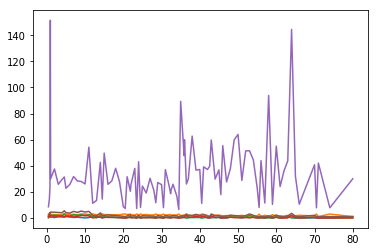

In [17]:
plt.plot(temp.groupby('Age').mean());

In [18]:
data[data.Age >= 60][['Survived', 'Name', 'Age']].sort_values(by='Age', ascending=False)


,Survived,Name,Age
PassengerId,,,
631,1,"Barkworth, Mr. Algernon Henry Wilson",80.0
852,0,"Svensson, Mr. Johan",74.0
494,0,"Artagaveytia, Mr. Ramon",71.0
97,0,"Goldschmidt, Mr. George B",71.0
117,0,"Connors, Mr. Patrick",70.5
746,0,"Crosby, Capt. Edward Gifford",70.0
673,0,"Mitchell, Mr. Henry Michael",70.0
34,0,"Wheadon, Mr. Edward H",66.0
281,0,"Duane, Mr. Frank",65.0


In [19]:
data[((data.Age >= 60) & (data.Survived == 1))][['Survived', 'Name', 'Age']].sort_values(by='Age', ascending=False)


,Survived,Name,Age
PassengerId,,,
631,1,"Barkworth, Mr. Algernon Henry Wilson",80.0
276,1,"Andrews, Miss. Kornelia Theodosia",63.0
484,1,"Turkula, Mrs. (Hedwig)",63.0
571,1,"Harris, Mr. George",62.0
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",62.0
367,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",60.0
588,1,"Frolicher-Stehli, Mr. Maxmillian",60.0


Възрастните хора, май нямат много късмет, но пък най-старият пътник е оцелял, и все пак тази информация не ни помага повече да разделим оформените групички от години

Да разгледаме билетите

In [20]:
data['Ticket'].sort_values(ascending=False).unique()


array(['WE/P 5735', 'W/C 14208', 'W.E.P. 5734', 'W./C. 6609', 'W./C. 6608',
       'W./C. 6607', 'W./C. 14263', 'W./C. 14258', 'SW/PP 751',
       'STON/O2. 3101290', 'STON/O2. 3101283', 'STON/O2. 3101282',
       'STON/O2. 3101279', 'STON/O2. 3101271', 'STON/O 2. 3101294',
       'STON/O 2. 3101293', 'STON/O 2. 3101292', 'STON/O 2. 3101289',
       'STON/O 2. 3101288', 'STON/O 2. 3101286', 'STON/O 2. 3101285',
       'STON/O 2. 3101280', 'STON/O 2. 3101275', 'STON/O 2. 3101274',
       'STON/O 2. 3101273', 'STON/O 2. 3101269', 'SOTON/OQ 392090',
       'SOTON/OQ 392089', 'SOTON/OQ 392086', 'SOTON/OQ 392082',
       'SOTON/OQ 392076', 'SOTON/OQ 3101317', 'SOTON/OQ 3101316',
       'SOTON/O2 3101287', 'SOTON/O2 3101272', 'SOTON/O.Q. 392087',
       'SOTON/O.Q. 392078', 'SOTON/O.Q. 3101312', 'SOTON/O.Q. 3101311',
       'SOTON/O.Q. 3101310', 'SOTON/O.Q. 3101307', 'SOTON/O.Q. 3101306',
       'SOTON/O.Q. 3101305', 'SO/C 14885', 'SCO/W 1585', 'SC/Paris 2163',
       'SC/Paris 2123', 'SC/PA

Отделям няколко групи според с каква буква/цифра започва билета   W,S,F,C,A,1,2,3

In [21]:
def one_hot_ticket(data): 
    data['TicketW'] = (data['Ticket'].astype(str).str[0]=='W').astype(float) 
    data['TicketS'] = (data['Ticket'].astype(str).str[0]=='S').astype(float) 
    data['TicketP'] = (data['Ticket'].astype(str).str[0]=='P').astype(float) 
    data['TicketF'] = (data['Ticket'].astype(str).str[0]=='F').astype(float) 
    data['TicketC'] = (data['Ticket'].astype(str).str[0]=='C').astype(float) 
    data['TicketA'] = (data['Ticket'].astype(str).str[0]=='A').astype(float) 
    data['Ticket1'] = (data['Ticket'].astype(str).str[0]=='1').astype(float) 
    data['Ticket2'] = (data['Ticket'].astype(str).str[0]=='2').astype(float) 
    data['Ticket3'] = (data['Ticket'].astype(str).str[0]=='3').astype(float) 

In [22]:
#one_hot_ticket(data) с този оne-hot нямаше
#някакаква голяма разлика в крайната оценка (локално), но при пускането в kaggle, даде резултат с близо 0.25 по-малко

Да видим цената на билетите

In [23]:
data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Имаме пътници, който не за заплатили билет, да видим какви групички можем да намерим 

In [24]:
temp = data.copy()
temp.loc[temp.Fare == 0, 'Fare'] = temp['Fare'].mean()
temp['Fare_Size']=pd.qcut(temp['Fare'],5)
temp.groupby(['Fare_Size'])['Survived'].mean().to_frame()

,Survived
Fare_Size,
"(4.011, 7.896]",0.206731
"(7.896, 11.5]",0.246667
"(11.5, 24.15]",0.429348
"(24.15, 39.688]",0.404624
"(39.688, 512.329]",0.642045


In [25]:
def one_hot_fare(data):
    data['Fare1'] = ((data.Fare> 4.011) & (data.Fare <= 11.5)).astype(float)
    data['Fare2'] = ((data.Fare > 11.5) & (data.Fare <= 24.15)).astype(float)
    data['Fare3'] = ((data.Fare > 24.15) & (data.Fare <= 39.688)).astype(float)
    data['Fare4'] = ((data.Fare > 39.688) & (data.Fare <= 512.329)).astype(float)

In [26]:
#one_hot_fare(data) с този оne-hot в комбинация  с one_hot_ticket нямаше
#някакаква голяма разлика в крайната оценка (локално), но при пускането в kaggle, даде резултат с близо 0.25 по-малко

<strong>Да оne-hot-ваме</strong>

In [27]:
def one_hot_title(data):
    for title in titles:
        data['Is' + title] = (data.Title == title).astype(float)

In [29]:
def one_hot_age(data): 
    data['Child'] = (data.Age <= 18).astype(float) 
    data['Student'] = ((data.Age > 18) & (data.Age <= 22)).astype(float) 
    data['Adult1'] = ((data.Age > 22) & (data.Age <= 28)).astype(float) 
    data['Adult2'] = ((data.Age > 28) & (data.Age <= 32.368)).astype(float) 
    data['Adult3'] = ((data.Age > 32.368) & (data.Age <= 34)).astype(float)
    data['Adult4'] = ((data.Age > 34) & (data.Age <= 43)).astype(float)
    data['Adult5'] = ((data.Age > 43) & (data.Age <= 80)).astype(float)

In [30]:
def one_hot_embarked(data):
    for harbour in ['S','C','Q']:
         data['Harbour' + harbour] = (data.Embarked == harbour).astype(float)

In [31]:
def one_hot_class(data):
    for c in [1,2,3]:
         data['Class' + str(c)] = (data.Pclass == c).astype(float)

In [32]:
def one_hot_family_size(data):
    data['Alone'] = (data.FamilySize == 1).astype(float)
    data['SmallFamily'] = ((data.FamilySize >= 2) & (data.FamilySize < 5)).astype(float)
    data['BigFamily'] = (data.FamilySize >= 5).astype(float)

In [33]:
def one_hot_sex(data):
    for sex in ['male','female']:
        data['Is' + sex.title()] = (data.Sex == sex).astype(float)

In [34]:
one_hot_title(data)
one_hot_age(data)
one_hot_embarked(data)
one_hot_class(data)
one_hot_family_size(data)
one_hot_sex(data)

<strong>Махаме ненужните колони и почваме да тренираме модел</strong>

In [35]:
data = data.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Age'],1)

In [36]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

<strong>Логистична регресия</strong>

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.836826347305
test score:  0.820627802691


<strong>Случайна гора :D</strong>

In [38]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.953592814371
test score:  0.793721973094


Много overfitting

<strong>Grid search с различни параметри</strong>

In [39]:
search = GridSearchCV(model, {'n_estimators': [5, 10, 20, 50, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
9,1,0.832772,"{'max_depth': 4, 'n_estimators': 100}"
6,2,0.831650,"{'max_depth': 4, 'n_estimators': 10}"
8,3,0.830527,"{'max_depth': 4, 'n_estimators': 50}"
5,4,0.829405,"{'max_depth': 4, 'n_estimators': 5}"
7,5,0.826038,"{'max_depth': 4, 'n_estimators': 20}"
13,6,0.819304,"{'max_depth': 6, 'n_estimators': 50}"
17,7,0.814815,"{'max_depth': 8, 'n_estimators': 20}"
14,7,0.814815,"{'max_depth': 6, 'n_estimators': 100}"
12,9,0.813692,"{'max_depth': 6, 'n_estimators': 20}"
11,9,0.813692,"{'max_depth': 6, 'n_estimators': 10}"


Пробваме с max_depth=4 и n_estimators=100

In [40]:
model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.820627802691


In [41]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

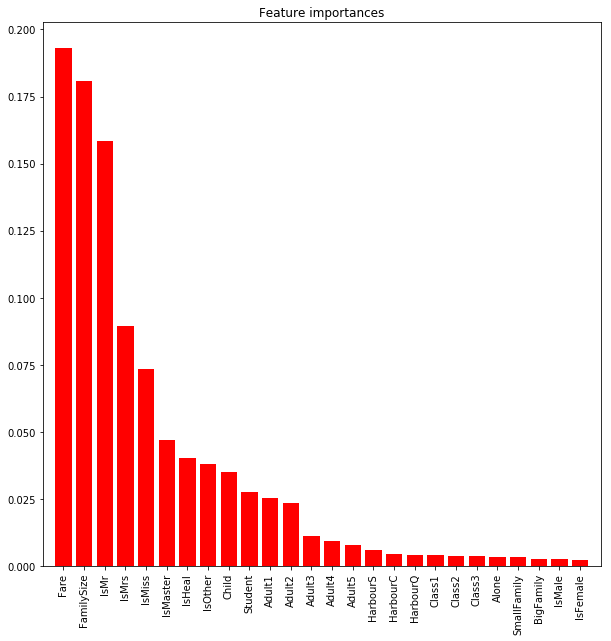

In [42]:
random_forest_features(model, X)


<strong>Fare, има голямо значение, но явно има друг подход към този feature(закоментираният one-hot, не даде исканите резултати)</strong>

In [43]:
test = pd.read_csv('data/titanic/test.csv', index_col=['PassengerId'])
create_title(test)
fix_names(test)
add_avg_age(test)
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
#one_hot_ticket(test)
one_hot_age(test)
one_hot_title(test)
one_hot_embarked(test)
one_hot_class(test)
one_hot_family_size(test)
one_hot_sex(test)
test.loc[test.Fare.isnull(), 'Fare'] = 0
test.loc[test.Fare == 0, 'Fare'] = test['Fare'].mean()
#one_hot_fare(test)
test = test.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Age'],1)
test.isnull().sum().sort_values()
predictions = model.predict(test)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('~/Desktop/predictions.csv')
frame.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


![LeadingBoard](attachment:img/kaggle_result.png)
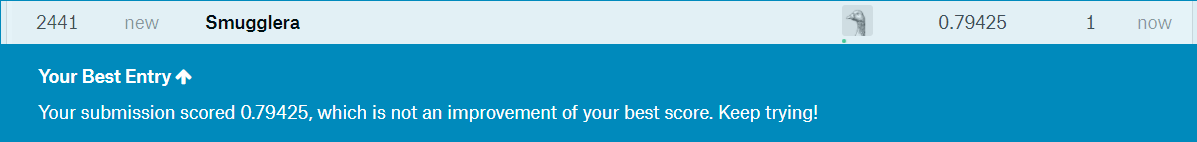